In [1]:
from nixtlats import NixtlaClient
import os

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = os.getenv("NIXTLATS_API_KEY")
)

# checking if the API key is valid
nixtla_client.validate_api_key()

INFO:nixtlats.nixtla_client:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io


True

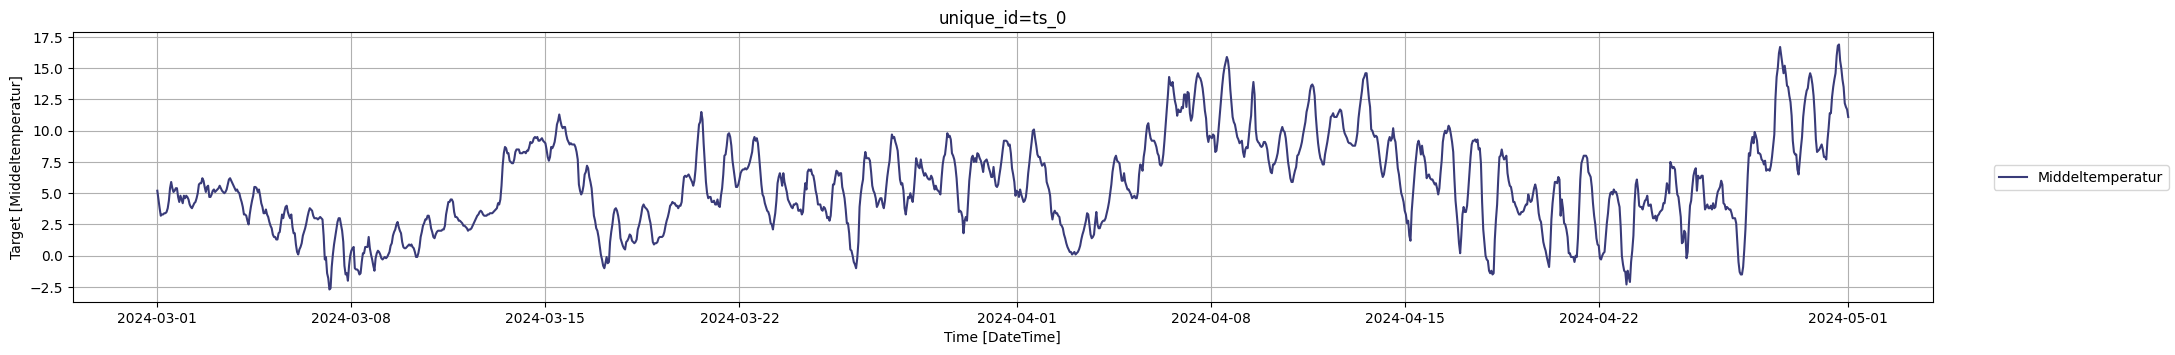

In [15]:
import pandas as pd 

all_data = pd.read_csv(os.path.join('..','data','weather', 'AarhusSydObservations', 'weatherAarhusSyd_Marts_april.csv'))

# remove variables from all the data (not necessary, just nice)
variables_to_remove = ['Luftfugtighed', 'Nedbør', 'Nedbørsminutter', 'Maksimumtemperatur', 'Minimumtemperatur', 'Skyhøjde', 'Middelvindhastighed', 'Skydække', 'Højeste vindstød']
all_data = all_data.drop(variables_to_remove, axis=1)


# plotting all data
nixtla_client.plot(all_data, time_col='DateTime', target_col='Middeltemperatur')

In [18]:
import pandas as pd

dataset = all_data
train_size = 1000
test_size = 50
horizon = 10
model_type = 'timegpt-1-long-horizon' # 'timegpt-1' or 'timegpt-1-long-horizon'
target_column = 'Middeltemperatur'
time_column = 'DateTime'
freqency = 'H'

def rolling_origin_forecast(train_size, test_size, horizon, dataset, time_column, target_column, freqency, model_type):
    all_predictions = []
    for start in range(train_size, (train_size+test_size) - horizon + 1):
        train_df = dataset.iloc[:start]

        # Predict the next 10 rows
        forecast_df = nixtla_client.forecast(
            df=train_df,
            h=horizon,
            time_col=time_column,
            target_col=target_column,
            freq=freqency,
            model=model_type,
        )

        # get the actual values for the prediction window
        actual_df = dataset.iloc[start:start + horizon][['DateTime', 'Middeltemperatur']]

        # Concatenate the actual and prediction dataframes
        results = forecast_df.copy()
        results['Actual'] = actual_df['Middeltemperatur'].values

        # Save the results in the list
        all_predictions.append(results)
    
    return all_predictions

results = rolling_origin_forecast(train_size, test_size, horizon, dataset, time_column, target_column, freqency, model_type)

results_df = pd.concat(results)
results_df['RollingOrigin'] = [i for i in range(len(results)) for _ in range(horizon)]

# save the results
results_df.to_csv(os.path.join('results', 'weather_data' f'train_{train_size}_test_{test_size}_horizon_{horizon}_weather_results.csv'), index=False)

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:

In [13]:
results_df.to_csv(os.path.join('results', 'weather_data' f'train_{train_size}_test_{test_size}_horizon_{horizon}_model_{model_type}_weather_results.csv'), index=False)

In [11]:
# Combine all results into a single DataFrame
final_predictions_df = pd.concat(all_predictions).reset_index(drop=True)

final_predictions_df['Roll'] = final_predictions_df.groupby(final_predictions_df.index // 50).ngroup() + 1

# save the results
final_predictions_df.to_csv(os.path.join(f"weather_1000_train_250_test_50_horizon_results.csv"), index=False)

In [57]:
import pandas as pd

def rolling_origin_forecast(df, horizon, time_col, target_col, output_file):
    all_predictions = []

    # Rolling origin procedure
    for start in range(len(df) - horizon + 1):
        train_df = df.iloc[:start]
        
        # Predict the next 'horizon' rows
        forecast_df = nixtla_client.forecast(
            df=train_df,
            h=horizon,
            time_col=time_col,
            target_col=target_col,
        )

        # get the actual values for the prediction window
        actual_df = df.iloc[start:start + horizon][[time_col, target_col]]
        
        # Concatenate the actual and prediction dataframes
        results = forecast_df.copy()
        results['Actual'] = actual_df[target_col].values
        
        # Save the results in the list
        all_predictions.append(results)

    # Combine all results into a single DataFrame
    final_predictions_df = pd.concat(all_predictions).reset_index(drop=True)

    # save the results
    final_predictions_df.to_csv(output_file, index=False)

    return final_predictions_df

In [ ]:
df = pd.read_csv('your_dataset.csv')
rolling_origin_forecast(df, horizon=10, time_col='DateTime', target_col='Middeltemperatur', output_file='results.csv')

functions

In [4]:
import pandas as pd
from pandas import DataFrame
import os

path_to_files = '../data/weather/AarhusSydObservations/data_partitions/'  # path to files
files = os.listdir(path_to_files)

# Filter out only the relevant CSV files (you may adjust the pattern if needed)
csv_files = [f for f in files if f.startswith('Partition') and f.endswith('.csv')]

# Load all partitions
partitions = {}
for file in csv_files:
    # Extracting the partition name and type (train or test)
    name, partition_type = file.replace('.csv', '').rsplit('_', 1)
    if name not in partitions:
        partitions[name] = {}
    partitions[name][partition_type] = pd.read_csv(path_to_files + file)

# Defining the forecasting function (this is a placeholder; you will need a real function)
def forecast_and_calculate_error(df_train, df_test, n_steps_to_forecast, time_collum, target_column, freq='h', model = 'timegpt-1'):
    """
    n_steps_to_forecast: steps ahead to forecast
    freq: frequency of the time series data (MS=month start, D=day etc.)
    time_col: name of the column with the time data
    target_col: name of the column with the target data
    """
    # forecasting h steps ahead
    timegpt_fcst_df = nixtla_client.forecast(df=df_train, h=n_steps_to_forecast, freq=freq, time_col=time_collum, target_col=target_column, model = model)

    df_test_new = df_test[[time_collum, target_column]] # selecting only the time and target column
    df_test_new_h = df_test_new[0:n_steps_to_forecast] # making the test data the same size as the forecast

    # calculating the error between TimeGPT column in the forecast and the target column
    timegpt_fcst_df_with_test = timegpt_fcst_df.join(df_test_new_h, lsuffix='_left', rsuffix='_right')
    timegpt_fcst_df_with_test['error'] = timegpt_fcst_df_with_test[target_column] - timegpt_fcst_df_with_test['TimeGPT']

    return timegpt_fcst_df_with_test

for partition, datasets in partitions.items():
    train_df = datasets['train']
    test_df = datasets['test']
    n_steps_to_forecast = len(test_df)  # 
    time_col = 'DateTime'  # # time column
    target_col = 'Middeltemperatur'  # target column

    # Perform your forecasting and error calculation here
    error_df = forecast_and_calculate_error(train_df, test_df, n_steps_to_forecast, time_col, target_col)

    # You can do something with the error_df here, like printing or storing the error statistics
    print(f"Results for {partition}:")
    print(error_df.head())  # For example, just print the first few rows of the error DataFrame

    # Optional: Saving the results back to CSV
    error_df.to_csv(f'{partition}_errors.csv', index=False)

INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...
INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


Results for Partition_test_120_train_750:
         DateTime_left   TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-26 01:00:00  3.085881  2024-04-26 01:00:00               4.0   
1  2024-04-26 02:00:00  2.774104  2024-04-26 02:00:00               3.7   
2  2024-04-26 03:00:00  2.592773  2024-04-26 03:00:00               4.2   
3  2024-04-26 04:00:00  2.454962  2024-04-26 04:00:00               3.8   
4  2024-04-26 05:00:00  2.544678  2024-04-26 05:00:00               3.9   

      error  
0  0.914119  
1  0.925896  
2  1.607227  
3  1.345038  
4  1.355322  


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


Results for Partition_test_12_train_250:
         DateTime_left    TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-30 13:00:00  14.180570  2024-04-30 13:00:00              14.6   
1  2024-04-30 14:00:00  14.109629  2024-04-30 14:00:00              16.0   
2  2024-04-30 15:00:00  14.226956  2024-04-30 15:00:00              16.8   
3  2024-04-30 16:00:00  14.082127  2024-04-30 16:00:00              16.9   
4  2024-04-30 17:00:00  13.882858  2024-04-30 17:00:00              15.6   

      error  
0  0.419430  
1  1.890371  
2  2.573044  
3  2.817873  
4  1.717142  


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


Results for Partition_test_120_train_50:
         DateTime_left   TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-26 01:00:00  3.508518  2024-04-26 01:00:00               4.0   
1  2024-04-26 02:00:00  3.498699  2024-04-26 02:00:00               3.7   
2  2024-04-26 03:00:00  3.308907  2024-04-26 03:00:00               4.2   
3  2024-04-26 04:00:00  3.171303  2024-04-26 04:00:00               3.8   
4  2024-04-26 05:00:00  3.186811  2024-04-26 05:00:00               3.9   

      error  
0  0.491482  
1  0.201301  
2  0.891093  
3  0.628697  
4  0.713189  


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


Results for Partition_test_12_train_750:
         DateTime_left    TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-30 13:00:00  14.180570  2024-04-30 13:00:00              14.6   
1  2024-04-30 14:00:00  14.109629  2024-04-30 14:00:00              16.0   
2  2024-04-30 15:00:00  14.226956  2024-04-30 15:00:00              16.8   
3  2024-04-30 16:00:00  14.082127  2024-04-30 16:00:00              16.9   
4  2024-04-30 17:00:00  13.882858  2024-04-30 17:00:00              15.6   

      error  
0  0.419430  
1  1.890371  
2  2.573044  
3  2.817873  
4  1.717142  


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


Results for Partition_test_120_train_250:
         DateTime_left   TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-26 01:00:00  3.085881  2024-04-26 01:00:00               4.0   
1  2024-04-26 02:00:00  2.774104  2024-04-26 02:00:00               3.7   
2  2024-04-26 03:00:00  2.592773  2024-04-26 03:00:00               4.2   
3  2024-04-26 04:00:00  2.454962  2024-04-26 04:00:00               3.8   
4  2024-04-26 05:00:00  2.544678  2024-04-26 05:00:00               3.9   

      error  
0  0.914119  
1  0.925896  
2  1.607227  
3  1.345038  
4  1.355322  


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


Results for Partition_test_12_train_50:
         DateTime_left    TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-30 13:00:00  14.123542  2024-04-30 13:00:00              14.6   
1  2024-04-30 14:00:00  14.296951  2024-04-30 14:00:00              16.0   
2  2024-04-30 15:00:00  14.118582  2024-04-30 15:00:00              16.8   
3  2024-04-30 16:00:00  13.919002  2024-04-30 16:00:00              16.9   
4  2024-04-30 17:00:00  13.533911  2024-04-30 17:00:00              15.6   

      error  
0  0.476458  
1  1.703049  
2  2.681418  
3  2.980998  
4  2.066089  


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


Results for Partition_test_360_train_50:
         DateTime_left   TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-16 01:00:00  5.557316  2024-04-16 01:00:00               5.9   
1  2024-04-16 02:00:00  5.389157  2024-04-16 02:00:00               5.7   
2  2024-04-16 03:00:00  5.123973  2024-04-16 03:00:00               5.8   
3  2024-04-16 04:00:00  4.940825  2024-04-16 04:00:00               5.4   
4  2024-04-16 05:00:00  4.870224  2024-04-16 05:00:00               4.9   

      error  
0  0.342684  
1  0.310843  
2  0.676027  
3  0.459175  
4  0.029776  


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...
INFO:nixtlats.nixtla_client:Validating inputs...
INFO:nixtlats.nixtla_client:Preprocessing dataframes...


Results for Partition_test_360_train_250:
         DateTime_left   TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-16 01:00:00  5.797980  2024-04-16 01:00:00               5.9   
1  2024-04-16 02:00:00  5.654299  2024-04-16 02:00:00               5.7   
2  2024-04-16 03:00:00  5.795963  2024-04-16 03:00:00               5.8   
3  2024-04-16 04:00:00  5.743681  2024-04-16 04:00:00               5.4   
4  2024-04-16 05:00:00  6.009033  2024-04-16 05:00:00               4.9   

      error  
0  0.102020  
1  0.045701  
2  0.004037  
3 -0.343681  
4 -1.109033  


INFO:nixtlats.nixtla_client:Calling Forecast Endpoint...


Results for Partition_test_360_train_750:
         DateTime_left   TimeGPT       DateTime_right  Middeltemperatur  \
0  2024-04-16 01:00:00  5.797980  2024-04-16 01:00:00               5.9   
1  2024-04-16 02:00:00  5.654299  2024-04-16 02:00:00               5.7   
2  2024-04-16 03:00:00  5.795963  2024-04-16 03:00:00               5.8   
3  2024-04-16 04:00:00  5.743681  2024-04-16 04:00:00               5.4   
4  2024-04-16 05:00:00  6.009033  2024-04-16 05:00:00               4.9   

      error  
0  0.102020  
1  0.045701  
2  0.004037  
3 -0.343681  
4 -1.109033  


In [2]:
import pandas as pd

# Define the datasets as strings for simplicity
data1 = """
images   Albert  Freja   Nikita  Sander  Emilio  Vibe    Hannah  Loui    Kristian    Noah    Amaya   Zack    Vega    Ali     Hasan   Zilan   Jan
Bjørn    5.7     7.3     4.7     23.3    14.2    17.6    7.0     1.3     12.6        27.6    10.1    11.5    16.0    1.7     2.1     26.3    9.8
Doktor   6.5     2.1     4.7     16.6    7.4     7.2     2.7     1.3     3.4         13.4    5.4     20.0    18.6    2.3     0.9     2.1     1.5
Galakse  11.8    4.4     5.9     18.0    9.7     39.7    27.2    14.1    7.3         24.0    7.0     25.3    19.0    0.8     11.5    8.0     7.5
Lyn      7.2     1.0     1.9     21.6    11.2    1.3     15.1    4.5     4.7         15.7    11.8    10.7    21.0    1.7     11.8    14.1    3.2
Rokke    11.7    3.0     10.3    23.3    5.4     24.6    20.7    17.9    3.1         18.9    10.5    18.7    13.6    1.1     18.7    4.3     3.3
Satellit 4.4     3.5     2.3     21.3    5.2     10.5    28.9    5.9     6.8         35.0    23.6    10.9    27.7    1.4     4.2     12.4    0.7
Sne      7.6     6.7     6.7     30.3    2.9     20.8    10.9    1.7     6.6         15.5    7.0     19.2    27.4    1.2     5.3     26.9    2.6
Solceller 19.8    5.7     4.6     19.5    5.7     9.7     55.5    3.4     7.9         14.2    1.3     11.9    13.2    1.0     0.6     37.2    1.1
Vulkan   10.8    3.0     1.9     20.4    12.1    3.8     0.7     27.6    9.6         24.4    5.6     10.3    21.8    0.5     8.4     15.3    0.9
Flod     7.3     4.2     6.9     28.5    5.0     14.7    13.9    1.1     2.4         14.6    1.3     16.6    0.1     1.0     8.1     34.9    13.5
Biler    6.1     4.4     2.0     19.3    5.9     3.8     9.4     13.2    5.4         29.2    1.4     19.5    13.7    0.8     0.9     12.2    52.5
Bog      6.1     1.7     1.7     7.4     5.7     1.6     19.2    0.8     5.8         12.1    1.6     9.2     16.5    0.7     1.0     10.5    3.5
Boldspil 6.9     3.6     1.8     23.6    5.3     5.2     23.5    2.9     4.4         15.4    2.8     17.3    10.9    3.2     8.9     2.4     4.4
Hesteløb 5.6     4.7     5.4     10.2    8.5     17.3    21.1    6.8     5.5         21.2    6.6     8.1     45.1    1.8     0.9     4.4     4.0
Koncert  10.7    3.7     2.5     14.7    3.2     8.3     17.5    5.7     4.9         9.6     15.4    27.9    14.3    1.0     0.7     12.0    1.7
Musik    9.2     3.4     7.8     9.1     7.7     2.4     6.5     1.7     2.3         17.4    2.7     20.0    11.7    1.8     0.7     8.2     7.2
Ruin     9.5     8.8     2.7     9.8     7.4     1.3     7.8     11.9    4.0         13.7    7.2     6.3     25.2    3.4     1.2     36.3    1.0
Rutsjebane 5.3    4.4     4.0     17.3    5.0     2.7     7.5     1.7     3.6         7.3     8.6     12.9    35.4    1.4     2.4     8.0     4.4
Skole    6.9     3.0     1.8     10.5    3.9     5.9     28.0    1.8     8.9         11.3    3.2     13.7    33.5    5.3     1.4     8.7     1.0
Skyskraber 9.0    2.0     1.9     22.5    4.6     2.4     38.5    0.8     3.3         8.3     5.7     13.4    21.4    0.9     1.2     11.6    0.8
"""
data2 = """
images   Albert  Freja   Nikita  Sander  Emilio  Vibe    Hannah  Loui    Kristian    Noah    Amaya   Zack    Vega    Ali     Hasan   Zilan   Jan
Bjørn    5.4     3.5     3.5     13.4    0.9     1.8     0.4     2.2     2.7         11.0    1.5     14.3    23.3    1.5     0.8     1.0     0.1
Doktor   14.9    1.5     1.6     7.3     1.8     4.7     28.2    1.6     2.7         7.6     2.0     9.4     4.6     1.6     49.4    1.5     0.7
Galakse  12.3    3.1     6.2     6.9     6.8     1.9     29.4    0.8     1.2         15.5    2.1     15.7    4.4     4.6     10.0    4.5     0.4
Lyn      6.1     6.1     2.2     4.5     2.7     2.5     3.4     0.8     1.2         16.0    2.8     6.8     6.1     1.2     1.2     1.9     2.2
Rokke    10.4    1.2     4.0     8.0     1.0     1.8     14.1    1.1     1.2         11.8    2.9     15.5    2.4     1.3     0.8     2.0     1.5
Satellit 8.3     3.6     2.4     8.9     2.5     2.1     23.5    5.6     1.3         17.8    0.5     10.8    3.0     3.3     1.0     1.5     1.1
Sne      11.9    10.0    4.1     5.5     1.3     4.3     7.2     1.1     1.5         14.8    2.7     6.7     3.3     1.1     1.2     1.6     0.9
Solceller 5.8     6.2     2.8     10.9    0.7     4.6     0.5     0.8     1.3         15.4    2.0     10.4    7.6     1.3     1.2     1.0     0.4
Vulkan   8.5     6.2     3.9     6.2     1.4     1.7     1.1     5.9     1.8         11.0    1.7     10.9    3.7     1.1     1.8     6.7     1.5
Flod     2.4     2.2     3.9     5.6     1.4     3.4     1.7     5.4     1.2         11.2    1.0     9.6     2.1     1.2     5.7     1.2     0.3
Biler    9.2     5.5     8.9     7.7     2.1     2.5     4.8     0.8     1.0         9.4     0.7     10.1    3.3     0.9     3.9     0.9     4.1
Bog      2.4     2.0     4.3     2.1     1.1     2.2     7.3     0.8     1.9         9.5     1.9     11.9    2.9     29.8    1.0     2.1     0.5
Boldspil 9.2     4.1     4.8     4.8     0.9     2.4     2.1     0.8     1.3         8.0     0.8     8.8     2.9     1.1     1.9     2.6     0.7
Hesteløb 3.5     3.9     3.5     4.7     1.1     3.6     10.6    0.8     4.4         9.7     0.5     10.3    4.4     1.3     5.2     1.4     0.3
Koncert  8.7     4.2     2.5     6.8     7.4     3.3     8.9     1.0     1.7         9.0     2.5     7.1     3.3     1.5     0.7     8.4     0.1
Musik    3.2     0.2     6.4     3.9     1.0     1.6     1.8     0.7     1.2         9.1     1.1     10.4    2.7     1.5     0.9     1.4     0.3
Ruin     4.5     1.7     1.5     5.0     1.1     2.9     0.6     0.9     1.8         12.7    1.9     9.6     3.6     1.0     5.0     8.8     0.3
Rutsjebane 8.4    7.3     7.0     4.7     0.8     3.1     1.5     1.6     0.8         4.9     1.8     11.5    3.5     0.8     0.6     1.3     0.3
Skole    5.4     5.1     3.1     6.1     1.3     1.5     4.6     2.0     1.5         8.8     1.8     8.2     3.6     3.0     1.2     2.6     0.3
Skyskraber 8.6    4.6     3.7     4.2     1.1     1.6     6.8     11.0    1.4         4.9     5.4     8.4     3.5     2.5     0.6     1.5     0.8
"""

# Read the datasets into Pandas DataFrames
from io import StringIO

# Read the datasets into Pandas DataFrames
df1 = pd.read_csv(StringIO(data1), sep=r'\s+')
df2 = pd.read_csv(StringIO(data2), sep=r'\s+')



# Add the 'test_type' column
df1['test_type'] = 'pre'
df2['test_type'] = 'post'

# Convert the DataFrames to tidy format
tidy_df1 = pd.melt(df1, id_vars=['images', 'test_type'], var_name='name', value_name='time')
tidy_df2 = pd.melt(df2, id_vars=['images', 'test_type'], var_name='name', value_name='time')

# Combine the tidy DataFrames
tidy_df = pd.concat([tidy_df1, tidy_df2], ignore_index=True)



In [3]:

# Add the 'image_type' and 'type_group' columns based on the given criteria
import pandas as pd
tidy_df['image_type'] = ['test' if i % 19 < 10 else 'control' for i in range(len(tidy_df))]
tidy_df['type_group'] = ['test' if tidy_df['name'][i] in ['Albert', 'Freja', 'Nikita', 'Sander', 'Emilio', 'Vibe', 'Hannah', 'Loui', 'Kristian'] else 'control' for i in range(len(tidy_df))]

# Rearrange columns
tidy_df = tidy_df[['name', 'images', 'image_type', 'type_group', 'time', 'test_type']]

# Print the resulting DataFrame
#print(tidy_df)_df))]
tidy_df['type_group'] = ['test' if tidy_df['name'][i] in ['Albert', 'Freja', 'Nikita', 'Sander', 'Emilio', 'Vibe', 'Hannah', 'Loui', 'Kristian'] else 'control' for i in range(len(tidy_df))]

# Rearrange columns
tidy_df = tidy_df[['name', 'images', 'image_type', 'type_group', 'time', 'test_type']]

# Print the resulting DataFrame
print(tidy_df)

       name      images image_type type_group  time test_type
0    Albert       Bjørn       test       test   5.7       pre
1    Albert      Doktor       test       test   6.5       pre
2    Albert     Galakse       test       test  11.8       pre
3    Albert         Lyn       test       test   7.2       pre
4    Albert       Rokke       test       test  11.7       pre
..      ...         ...        ...        ...   ...       ...
675     Jan       Musik    control    control   0.3      post
676     Jan        Ruin    control    control   0.3      post
677     Jan  Rutsjebane    control    control   0.3      post
678     Jan       Skole    control    control   0.3      post
679     Jan  Skyskraber    control    control   0.8      post

[680 rows x 6 columns]


In [4]:
# number of na's in each column
tidy_df.head(20)

# rename all names in the name column to 'name': Albert=D1, Freja=D2, Nikita=D3, Sander=D4, Emilio=D5, Vibe=D6, Hannah=D7, Loui=D8, Kristian=D9, Noah=D10, Amaya=D11, Zack=D12, Vega=D13, Ali=D14, Hasan=D15, Zilan=D16, Jan=D17
tidy_df['name'] = tidy_df['name'].replace({'Albert': 'D1', 'Freja': 'D2', 'Nikita': 'D3', 'Sander': 'D4', 'Emilio': 'D5', 'Vibe': 'D6', 'Hannah': 'D7', 'Loui': 'D8', 'Kristian': 'D9', 'Noah': 'D10', 'Amaya': 'D11', 'Zack': 'D12', 'Vega': 'D13', 'Ali': 'D14', 'Hasan': 'D15', 'Zilan': 'D16', 'Jan': 'D17'})

tidy_df



,name,images,image_type,type_group,time,test_type
0,D1,Bjørn,test,test,5.7,pre
1,D1,Doktor,test,test,6.5,pre
2,D1,Galakse,test,test,11.8,pre
3,D1,Lyn,test,test,7.2,pre
4,D1,Rokke,test,test,11.7,pre
...,...,...,...,...,...,...
675,D17,Musik,control,control,0.3,post
676,D17,Ruin,control,control,0.3,post
677,D17,Rutsjebane,control,control,0.3,post
678,D17,Skole,control,control,0.3,post


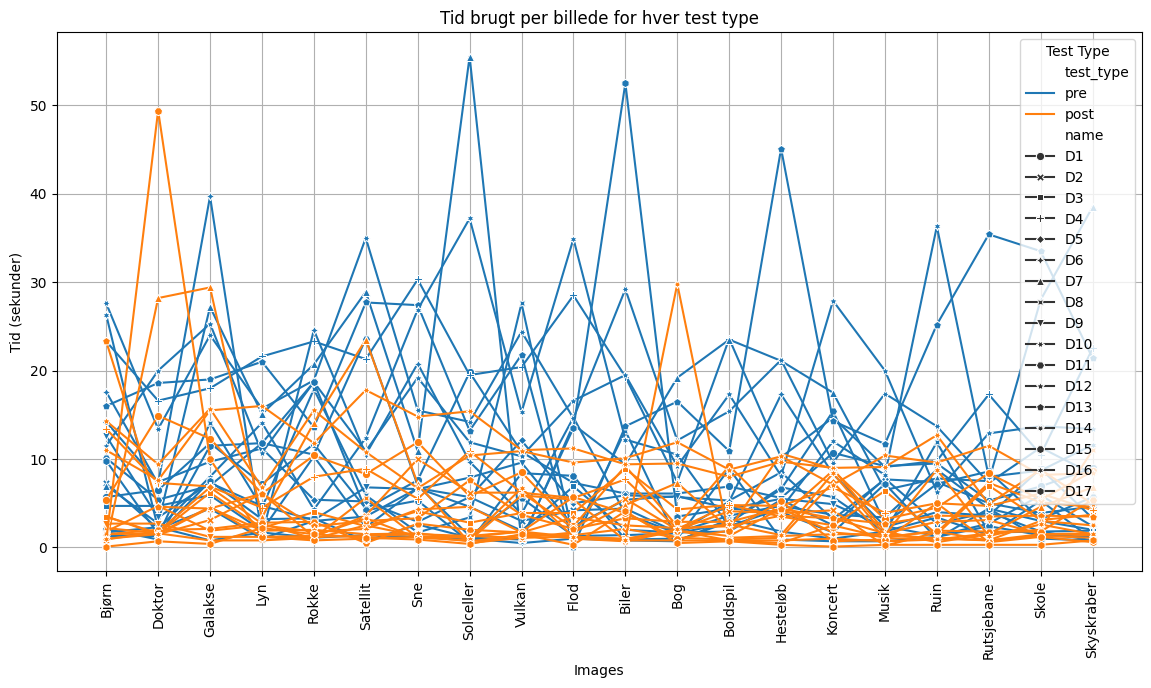

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(14, 7))

# Create a line plot
sns.lineplot(data=tidy_df, x='images', y='time', hue='test_type', style='name', markers=True, dashes=False)

# Customize the plot
plt.title('Tid brugt per billede for hver test type')
plt.xlabel('Images')
plt.ylabel('Tid (sekunder)')
plt.legend(title='Test Type')
plt.xticks(rotation=90)
plt.grid(True)

# Show the plot
plt.show()

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_93715/931236327.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=tidy_df, x='images', y='time', hue='test_type', ci=None)


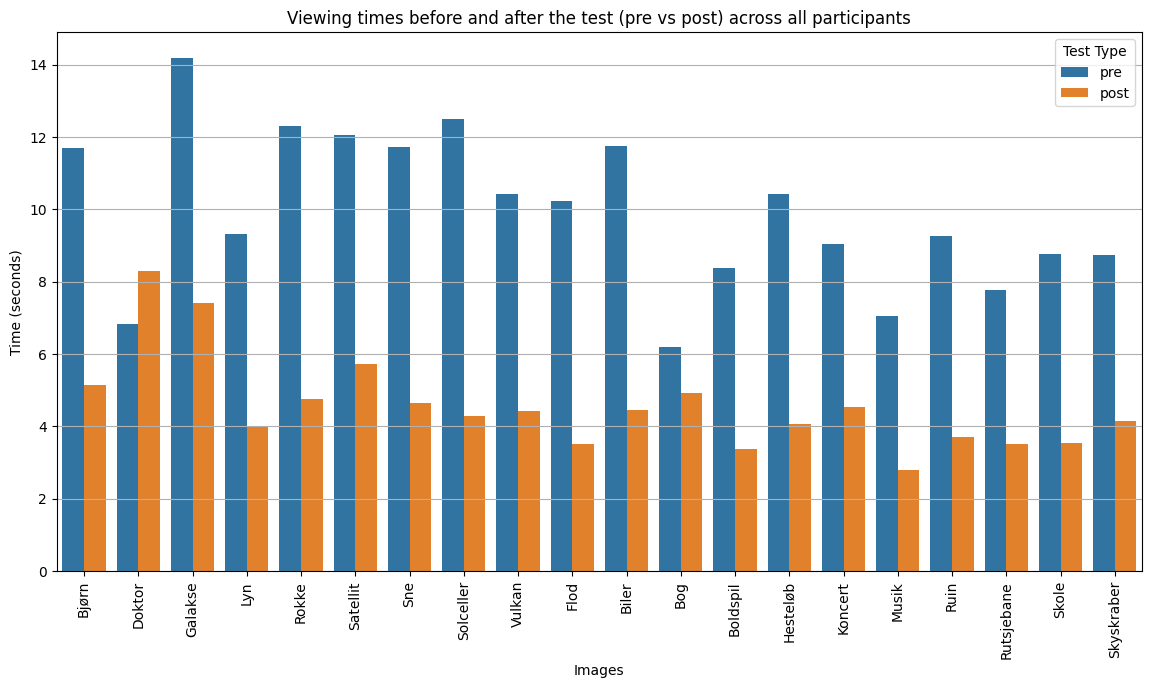

In [6]:
# Set up the figure
plt.figure(figsize=(14, 7))

# Create a grouped bar plot
sns.barplot(data=tidy_df, x='images', y='time', hue='test_type', ci=None)

# Customize the plot
plt.title('Viewing times before and after the test (pre vs post) across all participants')
plt.xlabel('Images')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=90)
plt.legend(title='Test Type')
plt.grid(axis='y')

# Show the plot
plt.show()

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_93715/1487429394.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=test_df, x='images', y='time', hue='test_type', ci=None)


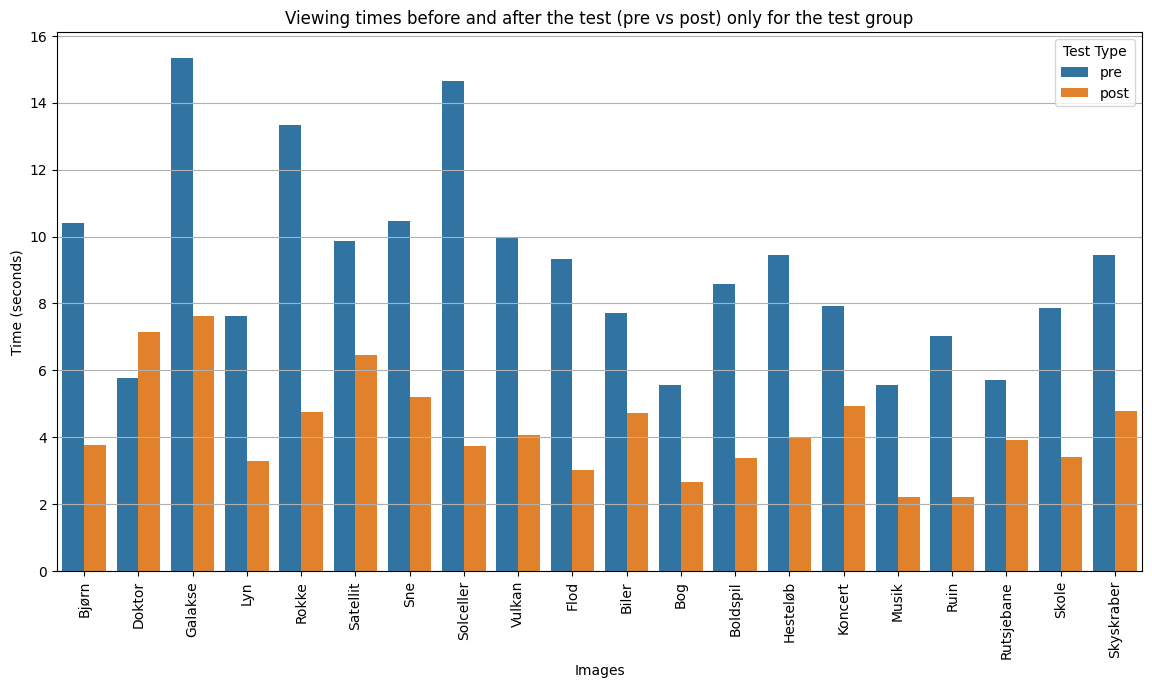

In [7]:
# Filter the DataFrame for only 'test' type_group
test_df = tidy_df[tidy_df['type_group'] == 'test']

# Set up the figure
plt.figure(figsize=(14, 7))

# Create a grouped bar plot
sns.barplot(data=test_df, x='images', y='time', hue='test_type', ci=None)

# Customize the plot
plt.title('Viewing times before and after the test (pre vs post) only for the test group')
plt.xlabel('Images')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=90)
plt.legend(title='Test Type')
plt.grid(axis='y')

# Show the plot
plt.show()

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_93715/2902534956.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=test_df, x='images', y='time', hue='test_type', ci=None)


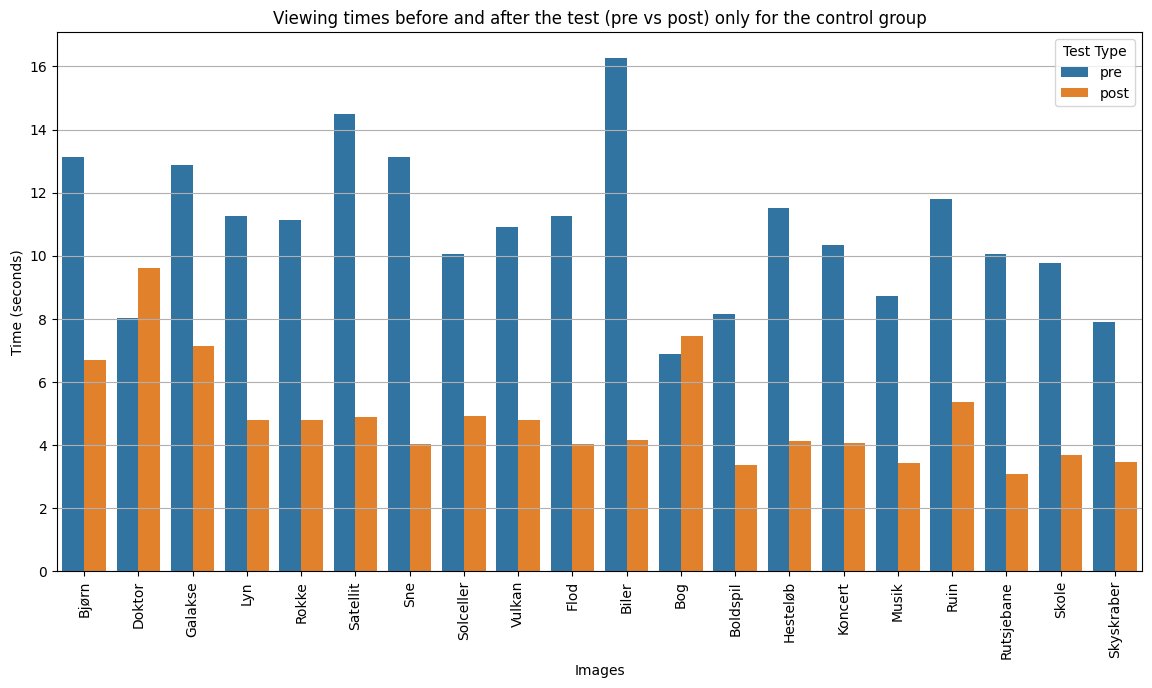

In [8]:

# Filter the DataFrame for only 'test' type_group
test_df = tidy_df[tidy_df['type_group'] == 'control']

# Set up the figure
plt.figure(figsize=(14, 7))

# Create a grouped bar plot
sns.barplot(data=test_df, x='images', y='time', hue='test_type', ci=None)

# Customize the plot
plt.title('Viewing times before and after the test (pre vs post) only for the control group')
plt.xlabel('Images')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=90)
plt.legend(title='Test Type')
plt.grid(axis='y')

# Show the plot
plt.show()

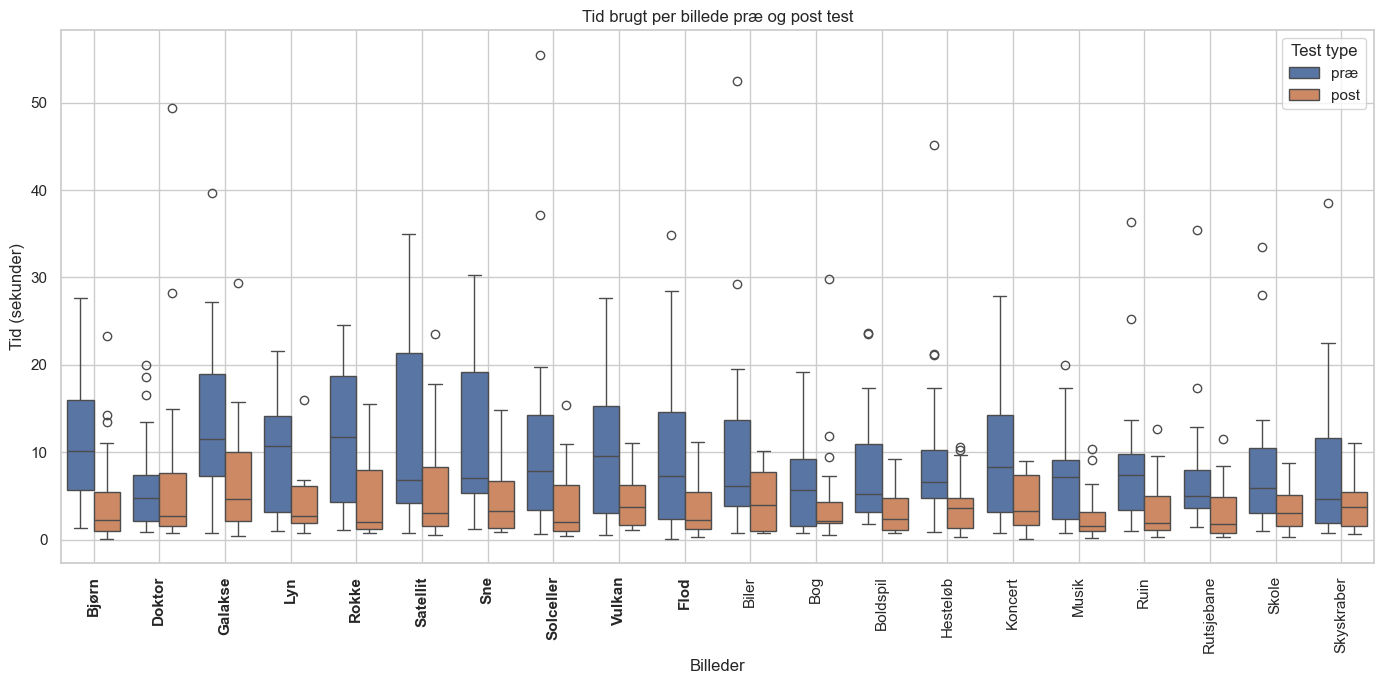

In [34]:
# Set up the figure
plt.figure(figsize=(14, 7))

# Create a box plot
sns.boxplot(data=tidy_df, x='images', y='time', hue='test_type')

# Customize the plot
plt.title('Tid brugt per billede præ og post test')
plt.xlabel('Billeder')
plt.ylabel('Tid (sekunder)')
plt.xticks(rotation=90)
plt.grid(True)

# Get the current legend labels
handles, labels = plt.gca().get_legend_handles_labels()

# Set the legend labels to new values
plt.legend(handles, ['præ', 'post'], title='Test type')

# Get the xtick labels
xticks = plt.gca().get_xticklabels()

# Set the weight of the first 10 labels to 'bold'
for i in range(10):
    xticks[i].set_weight('bold')

# Adjust the layout
plt.tight_layout()

# Save the figure
plt.savefig('../../../../../../../Desktop/figurer/tid_brugt_post_præ_alle.png')

# Show the plot
plt.show()

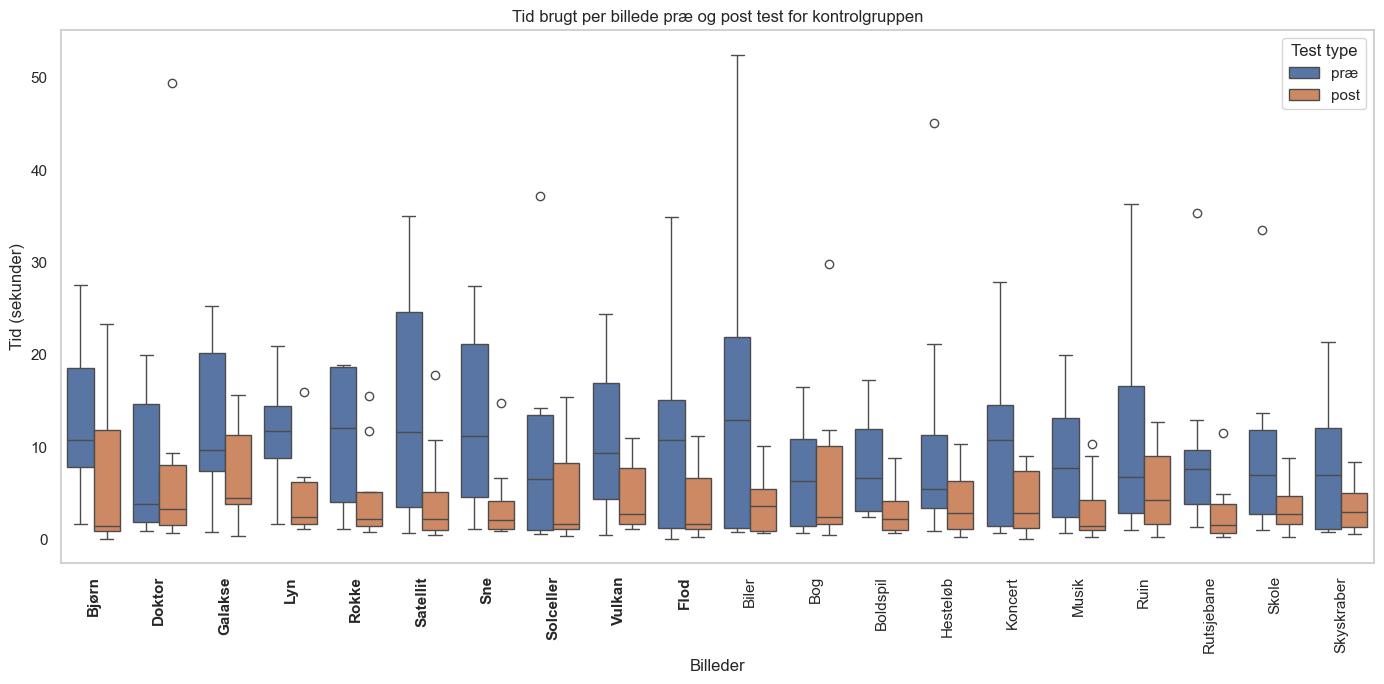

In [98]:
# Filter the DataFrame for only 'control' type_group
control_df = tidy_df[tidy_df['type_group'] == 'control']

# Set up the figure
plt.figure(figsize=(14, 7))

# Create a box plot
sns.boxplot(data=control_df, x='images', y='time', hue='test_type')

# Customize the plot
plt.title('Tid brugt per billede præ og post test for kontrolgruppen')
plt.xlabel('Billeder')
plt.ylabel('Tid (sekunder)')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Get the current legend labels
handles, labels = plt.gca().get_legend_handles_labels()

# Set the legend labels to new values
plt.legend(handles, ['præ', 'post'], title='Test type')

# Get the xtick labels
xticks = plt.gca().get_xticklabels()

# Set the weight of the first 10 labels to 'bold'
for i in range(10):
    xticks[i].set_weight('bold')

# Adjust the layout
plt.tight_layout()

plt.savefig('../../../../../../../Desktop/figurer/tid_brugt_post_præ_kontrolgruppe.png')

# Show the plot
plt.show()

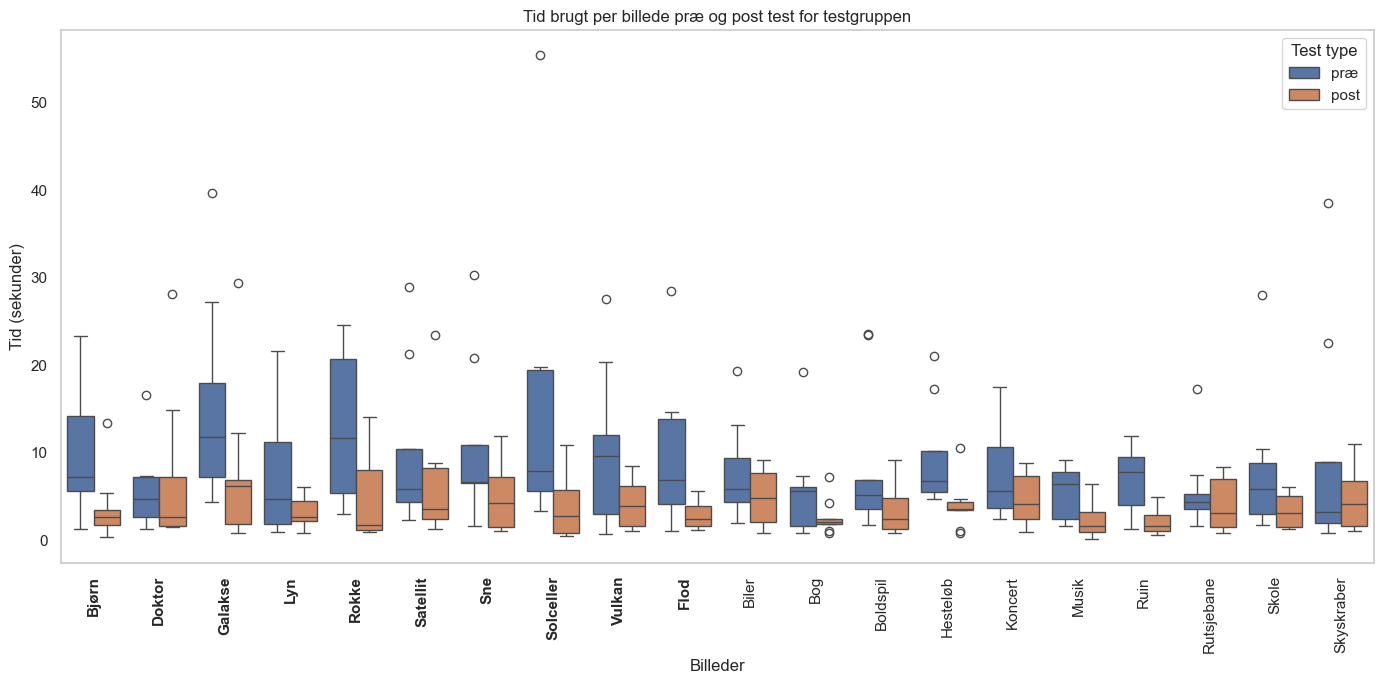

In [99]:
# Filter the DataFrame for only 'control' type_group
control_df = tidy_df[tidy_df['type_group'] == 'test']

# Set up the figure
plt.figure(figsize=(14, 7))

# Create a box plot
sns.boxplot(data=control_df, x='images', y='time', hue='test_type')

# Customize the plot
plt.title('Tid brugt per billede præ og post test for testgruppen')
plt.xlabel('Billeder')
plt.ylabel('Tid (sekunder)')
plt.xticks(rotation=90)
plt.grid(axis='y')

# Get the current legend labels
handles, labels = plt.gca().get_legend_handles_labels()

# Set the legend labels to new values
plt.legend(handles, ['præ', 'post'], title='Test type')

# Get the xtick labels
xticks = plt.gca().get_xticklabels()

# Set the weight of the first 10 labels to 'bold'
for i in range(10):
    xticks[i].set_weight('bold')

# Adjust the layout
plt.tight_layout()

plt.savefig('../../../../../../../Desktop/figurer/tid_brugt_post_præ_testgruppen.png')

# Show the plot
plt.show()

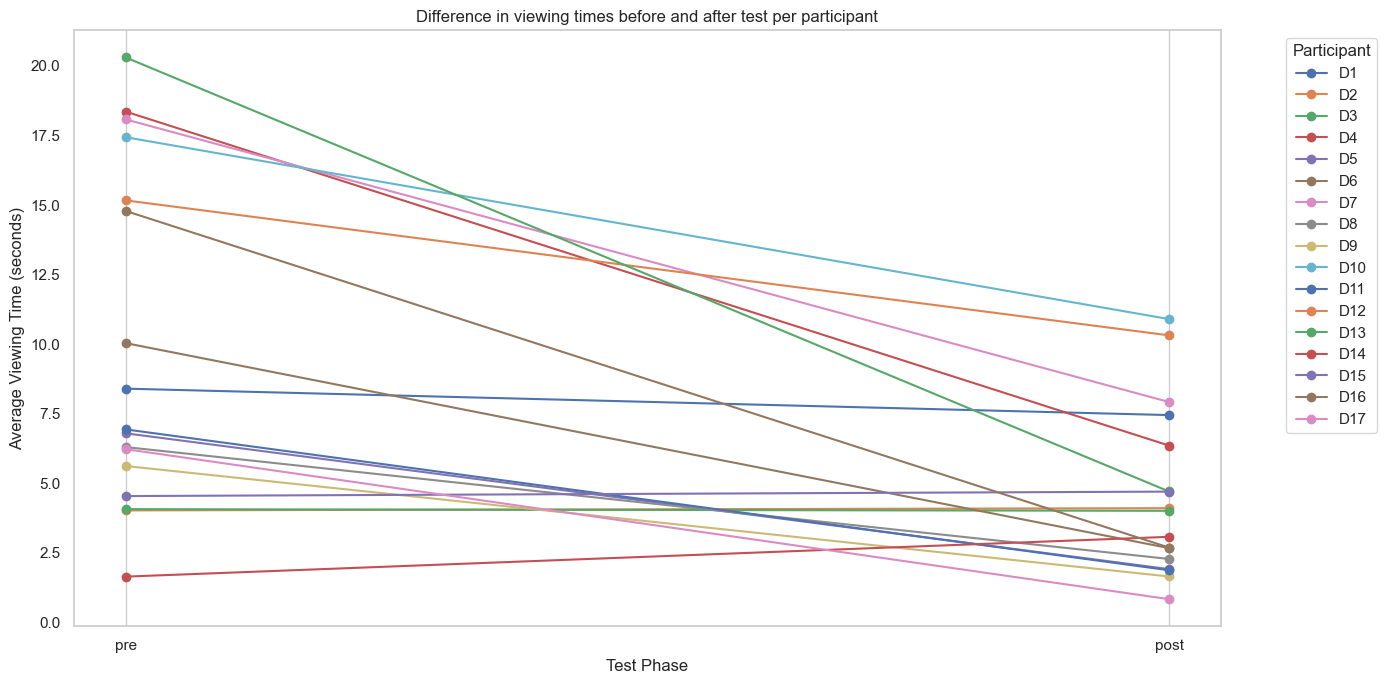

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We assume tidy_df is your DataFrame

# Transform data for better plotting
participants = tidy_df['name'].unique()
plot_data = []

for participant in participants:
    pre_times = tidy_df[(tidy_df['name'] == participant) & (tidy_df['test_type'] == 'pre')].set_index('images')['time']
    post_times = tidy_df[(tidy_df['name'] == participant) & (tidy_df['test_type'] == 'post')].set_index('images')['time']
    
    # Merge the times to make sure we only plot paired data with the same images
    paired_data = pd.DataFrame({'pre': pre_times, 'post': post_times}).dropna()
    
    for image in paired_data.index:
        plot_data.append({
            'participant': participant, 
            'image': image, 
            'pre_time': paired_data.loc[image, 'pre'], 
            'post_time': paired_data.loc[image, 'post'], 
            'difference': paired_data.loc[image, 'post'] - paired_data.loc[image, 'pre']
        })

plot_df = pd.DataFrame(plot_data)

# Create the plot
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Plot for each participant
for participant in plot_df['participant'].unique():
    participant_data = plot_df[plot_df['participant'] == participant]
    plt.plot(['pre', 'post'], [participant_data['pre_time'].mean(), participant_data['post_time'].mean()], marker='o', label=participant)

# Customizing plot
plt.title('Difference in viewing times before and after test per participant')
plt.xlabel('Test Phase')
plt.ylabel('Average Viewing Time (seconds)')
plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

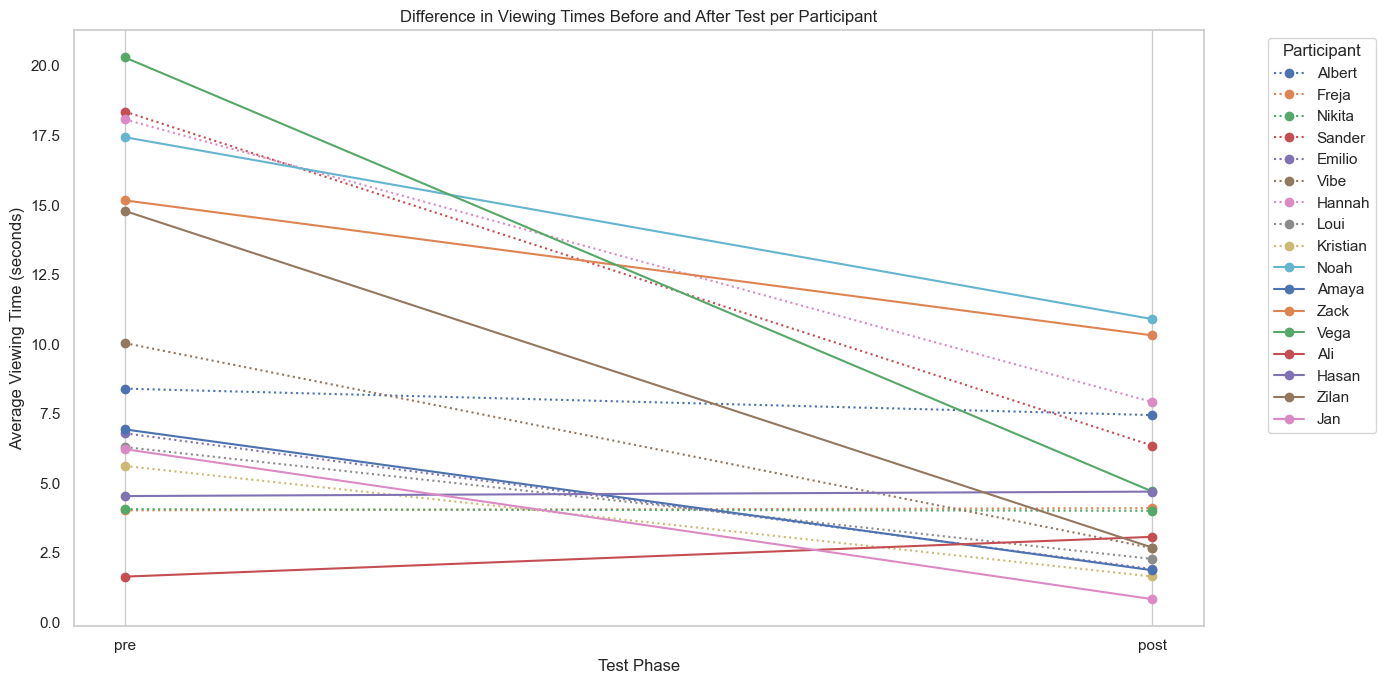

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We assume tidy_df is your DataFrame

# Transform data for better plotting
participants = tidy_df['name'].unique()
plot_data = []

for participant in participants:
    pre_times = tidy_df[(tidy_df['name'] == participant) & (tidy_df['test_type'] == 'pre')].set_index('images')['time']
    post_times = tidy_df[(tidy_df['name'] == participant) & (tidy_df['test_type'] == 'post')].set_index('images')['time']
    
    # Merge the times to make sure we only plot paired data with the same images
    paired_data = pd.DataFrame({'pre': pre_times, 'post': post_times}).dropna()
    
    for image in paired_data.index:
        plot_data.append({
            'participant': participant, 
            'image': image, 
            'pre_time': paired_data.loc[image, 'pre'], 
            'post_time': paired_data.loc[image, 'post'], 
            'difference': paired_data.loc[image, 'post'] - paired_data.loc[image, 'pre']
        })

plot_df = pd.DataFrame(plot_data)

# List of participants to be plotted with dotted lines
dotted_line_participants = ['Albert', 'Freja', 'Nikita', 'Sander', 'Emilio', 'Vibe', 'Hannah', 'Loui', 'Kristian']

# Create the plot
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Plot for each participant
for participant in plot_df['participant'].unique():
    participant_data = plot_df[plot_df['participant'] == participant]
    if participant in dotted_line_participants:
        plt.plot(
            ['pre', 'post'], 
            [participant_data['pre_time'].mean(), participant_data['post_time'].mean()], 
            marker='o', 
            linestyle=':',  # Dotted line style
            label=participant
        )
    else:
        plt.plot(
            ['pre', 'post'], 
            [participant_data['pre_time'].mean(), participant_data['post_time'].mean()], 
            marker='o', 
            linestyle='-',  # Solid line style
            label=participant
        )

# Customizing plot
plt.title('Difference in Viewing Times Before and After Test per Participant')
plt.xlabel('Test Phase')
plt.ylabel('Average Viewing Time (seconds)')
plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

Forskellen mellem præ og post for hhv kontrol- og testbilleder for begge grupper = 4 plots + underbyggende t-tests (ANOVA)

Now make a statistical test on the difference between post and pre for both groups (type_groups) and type og images (images_type (test or control)). It should end out with four different analysis: 1. The difference in test group before and after the test on the time they spend on the test pictures. 2. the difference in the control group before and after the test on the time they spend on the test pictures. 3. the difference in the test group before and after the test on the time they spend on the control pictures. 4. the difference in the control group before and after the test on the time they spend on the control pictures.

In [10]:
tidy_df

,name,images,image_type,type_group,time,test_type
0,D1,Bjørn,test,test,5.7,pre
1,D1,Doktor,test,test,6.5,pre
2,D1,Galakse,test,test,11.8,pre
3,D1,Lyn,test,test,7.2,pre
4,D1,Rokke,test,test,11.7,pre
...,...,...,...,...,...,...
675,D17,Musik,control,control,0.3,post
676,D17,Ruin,control,control,0.3,post
677,D17,Rutsjebane,control,control,0.3,post
678,D17,Skole,control,control,0.3,post


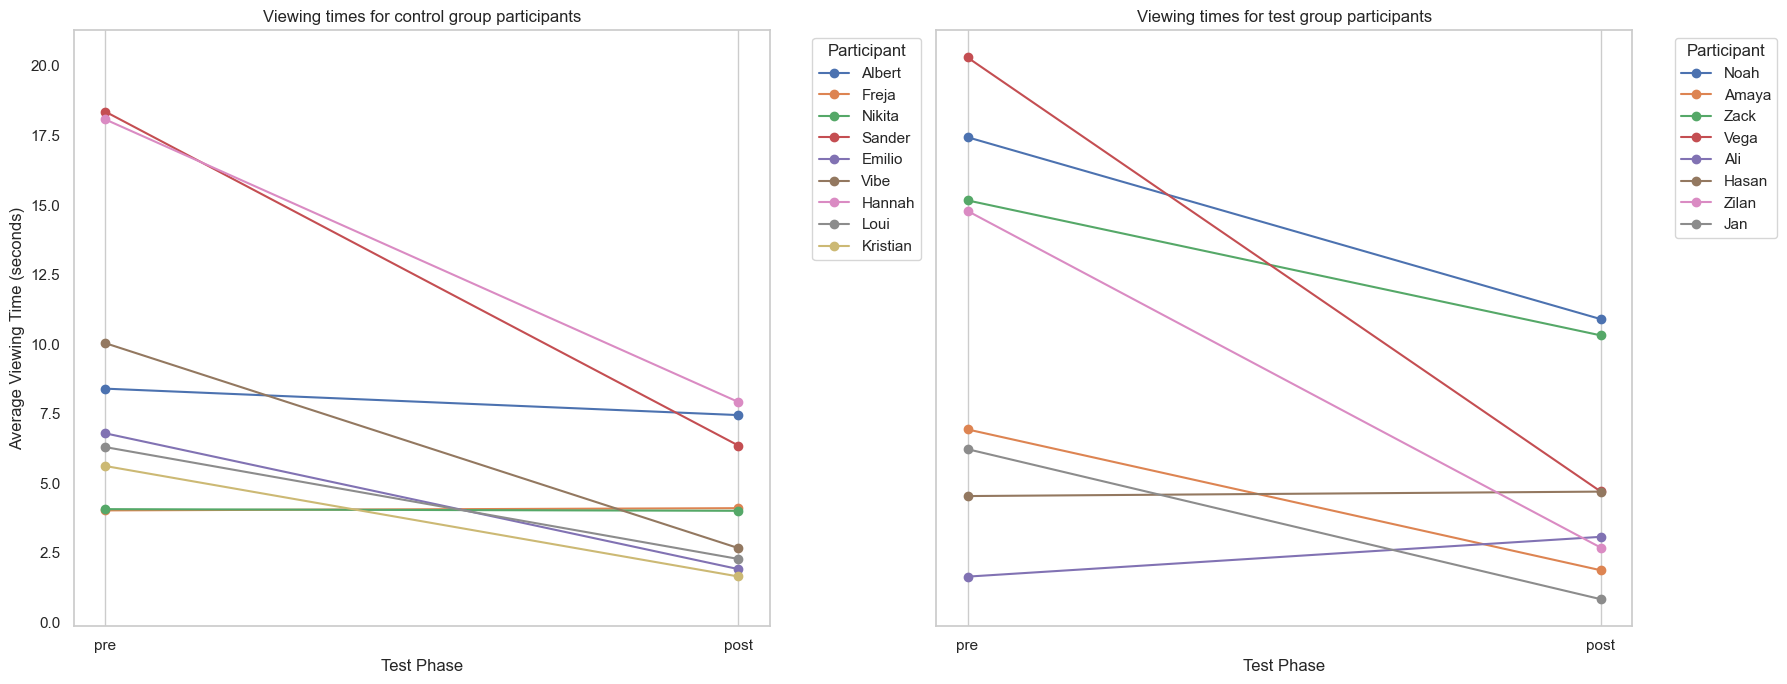

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We assume tidy_df is your DataFrame

# Transform data for better plotting
participants = tidy_df['name'].unique()
plot_data = []

for participant in participants:
    pre_times = tidy_df[(tidy_df['name'] == participant) & (tidy_df['test_type'] == 'pre')].set_index('images')['time']
    post_times = tidy_df[(tidy_df['name'] == participant) & (tidy_df['test_type'] == 'post')].set_index('images')['time']
    
    # Merge the times to make sure we only plot paired data with the same images
    paired_data = pd.DataFrame({'pre': pre_times, 'post': post_times}).dropna()
    
    for image in paired_data.index:
        plot_data.append({
            'participant': participant, 
            'image': image, 
            'pre_time': paired_data.loc[image, 'pre'], 
            'post_time': paired_data.loc[image, 'post'], 
            'difference': paired_data.loc[image, 'post'] - paired_data.loc[image, 'pre']
        })

plot_df = pd.DataFrame(plot_data)

# List of participants to be plotted in first plot
group_participants = ['Albert', 'Freja', 'Nikita', 'Sander', 'Emilio', 'Vibe', 'Hannah', 'Loui', 'Kristian']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
sns.set(style="whitegrid")

# Plotting participants in group_participants with solid lines
for participant in group_participants:
    participant_data = plot_df[plot_df['participant'] == participant]
    axes[0].plot(
        ['pre', 'post'], 
        [participant_data['pre_time'].mean(), participant_data['post_time'].mean()], 
        marker='o', 
        linestyle='-',  # Solid line style
        label=participant
    )
axes[0].set_title('Viewing times for control group participants')
axes[0].set_xlabel('Test Phase')
axes[0].set_ylabel('Average Viewing Time (seconds)')
axes[0].legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(axis='y')

# Plotting remaining participants with solid lines
for participant in [p for p in participants if p not in group_participants]:
    participant_data = plot_df[plot_df['participant'] == participant]
    axes[1].plot(
        ['pre', 'post'], 
        [participant_data['pre_time'].mean(), participant_data['post_time'].mean()], 
        marker='o', 
        linestyle='-',  # Solid line style
        label=participant
    )
axes[1].set_title('Viewing times for test group participants')
axes[1].set_xlabel('Test Phase')
axes[1].legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(axis='y')

# Adjust layout
plt.tight_layout()
plt.show()

In [66]:
print(tidy_df)

       name      images image_type type_group  time test_type
0    Albert       Bjørn       test       test   5.7       pre
1    Albert      Doktor       test       test   6.5       pre
2    Albert     Galakse       test       test  11.8       pre
3    Albert         Lyn       test       test   7.2       pre
4    Albert       Rokke       test       test  11.7       pre
..      ...         ...        ...        ...   ...       ...
675     Jan       Musik    control    control   0.3      post
676     Jan        Ruin    control    control   0.3      post
677     Jan  Rutsjebane    control    control   0.3      post
678     Jan       Skole    control    control   0.3      post
679     Jan  Skyskraber    control    control   0.8      post

[680 rows x 6 columns]


1. (Forskellen i tid før og efter test)
2. Forskellen i tid før og efter test per deltager
3. forskellen i tid før og efter test per gruppe (test/kontrol)
4. OBS: det er de samme billeder man ser to gange; måske skal det tages med i betragtning.

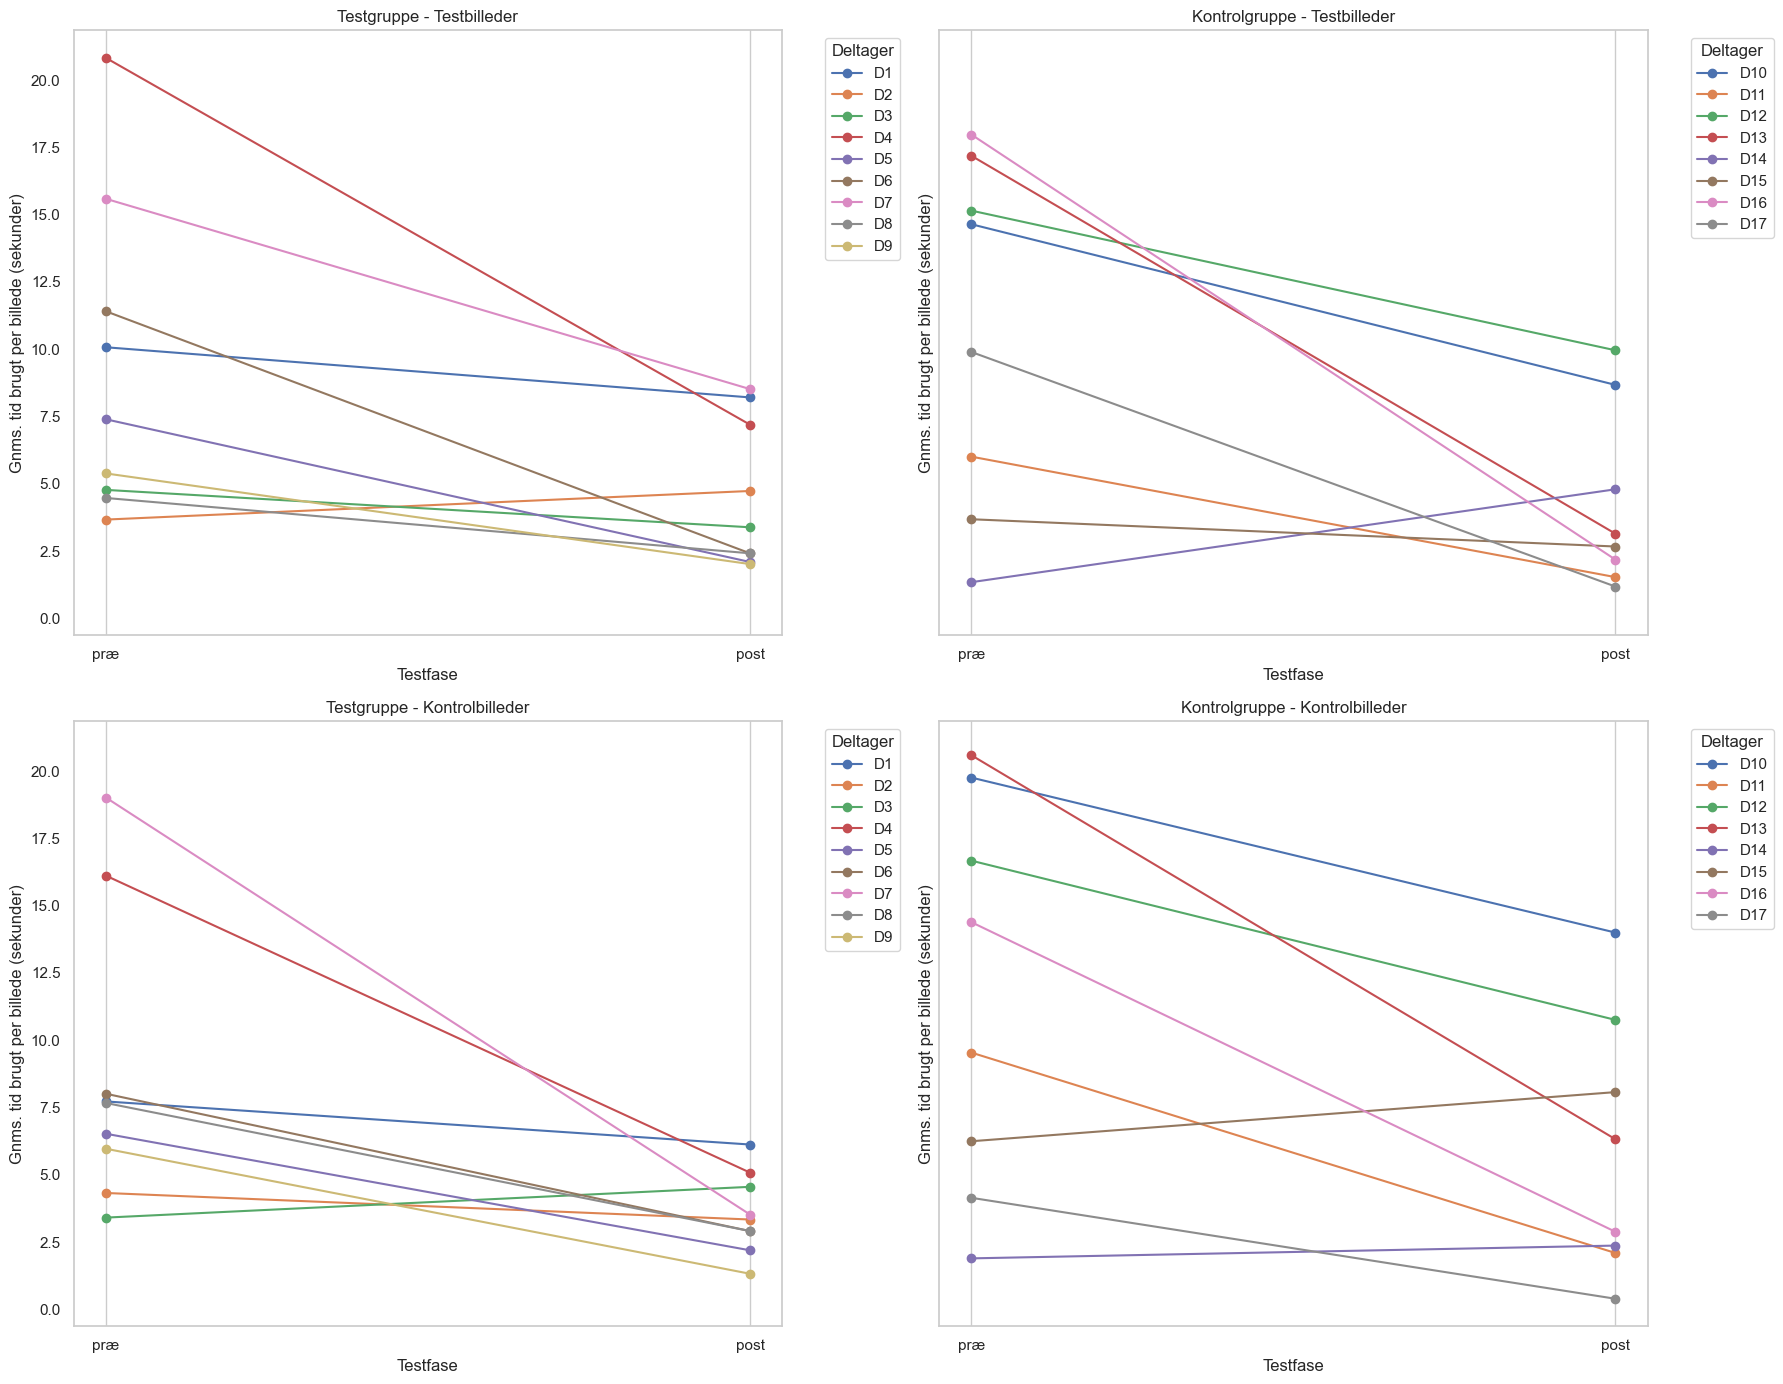

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We assume tidy_df is your DataFrame

# Transform data for better plotting
def gather_plot_data(group, img_type):
    plot_data = []
    participants = tidy_df[tidy_df['type_group'] == group]['name'].unique()
    
    for participant in participants:
        pre_times = tidy_df[(tidy_df['name'] == participant) & 
                            (tidy_df['test_type'] == 'pre') & 
                            (tidy_df['image_type'] == img_type)].set_index('images')['time']
        
        post_times = tidy_df[(tidy_df['name'] == participant) & 
                             (tidy_df['test_type'] == 'post') & 
                             (tidy_df['image_type'] == img_type)].set_index('images')['time']
        
        # Merge the times to make sure we only plot paired data with the same images
        paired_data = pd.DataFrame({'pre': pre_times, 'post': post_times}).dropna()
        
        for image in paired_data.index:
            plot_data.append({
                'participant': participant, 
                'image': image, 
                'pre_time': paired_data.loc[image, 'pre'], 
                'post_time': paired_data.loc[image, 'post'], 
                'difference': paired_data.loc[image, 'post'] - paired_data.loc[image, 'pre']
            })

    return pd.DataFrame(plot_data)

# Gather data for each scenario
plot_df_1 = gather_plot_data('test', 'test')
plot_df_2 = gather_plot_data('control', 'test')
plot_df_3 = gather_plot_data('test', 'control')
plot_df_4 = gather_plot_data('control', 'control')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14), sharey=True)
sns.set(style="whitegrid")

# Create a function to plot data

def plot_data(df, ax, title):
    participants = df['participant'].unique()
    for participant in participants:
        participant_data = df[df['participant'] == participant]
        ax.plot(
            ['præ', 'post'], 
            [participant_data['pre_time'].mean(), participant_data['post_time'].mean()], 
            marker='o', 
            linestyle='-',  # Solid line style
            label=participant
        )
    ax.set_title(title)
    ax.set_xlabel('Testfase')
    ax.set_ylabel('Gnms. tid brugt per billede (sekunder)')
    ax.legend(title='Deltager', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(axis='y')

# Plot each scenario
plot_data(plot_df_1, axes[0, 0], 'Testgruppe - Testbilleder')
plot_data(plot_df_2, axes[0, 1], 'Kontrolgruppe - Testbilleder')
plot_data(plot_df_3, axes[1, 0], 'Testgruppe - Kontrolbilleder')
plot_data(plot_df_4, axes[1, 1], 'Kontrolgruppe - Kontrolbilleder')

plt.tight_layout()
# save plot
plt.savefig('../../../../../../../Desktop/figurer/tid_brugt_post_præ_test_kontrol_og_test_kontrol_billeder.png')

# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
from scipy.stats import ttest_rel, ttest_ind

# Assumption: tidy_df is your DataFrame

# 1. Overall Difference in Time Before and After the Test
overall_pre = tidy_df[tidy_df['test_type'] == 'pre']['time']
overall_post = tidy_df[tidy_df['test_type'] == 'post']['time']

# Paired t-test
overall_ttest = ttest_rel(overall_pre, overall_post)
print(f"Paired t-test results (overall): {overall_ttest}")

# 2. Difference in Time Before and After the Test per Participant
participants = tidy_df['name'].unique()
participant_diffs = {}

for participant in participants:
    pre_times = tidy_df[(tidy_df['name'] == participant) & (tidy_df['test_type'] == 'pre')]['time']
    post_times = tidy_df[(tidy_df['name'] == participant) & (tidy_df['test_type'] == 'post')]['time']
    
    # Paired t-test per participant
    if len(pre_times) == len(post_times):
        ttest_result = ttest_rel(pre_times, post_times)
        participant_diffs[participant] = ttest_result.pvalue
    else:
        print(f"Unequal sample sizes for participant {participant}")

print("Paired t-test p-values per participant:")
print(participant_diffs)

# 3. Difference in Time Before and After the Test per Group (Test/Control)
for group in tidy_df['type_group'].unique():
    group_data = tidy_df[tidy_df['type_group'] == group]
    
    pre_times = group_data[group_data['test_type'] == 'pre']['time']
    post_times = group_data[group_data['test_type'] == 'post']['time']
    
    # Paired t-test per group
    group_ttest = ttest_rel(pre_times, post_times)
    print(f"Paired t-test results for {group} group: {group_ttest}")

# You can also aggregate and compare means if you're interested in a simpler summary statistic
# Mean difference overall
mean_difference_overall = overall_post.mean() - overall_pre.mean()
print(f"Mean difference overall: {mean_difference_overall}")

# Mean difference per group
for group in tidy_df['type_group'].unique():
    group_data = tidy_df[tidy_df['type_group'] == group]
    
    pre_mean = group_data[group_data['test_type'] == 'pre']['time'].mean()
    post_mean = group_data[group_data['test_type'] == 'post']['time'].mean()
    
    mean_difference = post_mean - pre_mean
    print(f"Mean difference for {group} group: {mean_difference}")

Paired t-test results (overall): TtestResult(statistic=10.569766034646683, pvalue=9.274147942291236e-23, df=339)
Paired t-test p-values per participant:
{'D1': 0.38014284045862, 'D2': 0.9012110126135982, 'D3': 0.9268770793298216, 'D4': 3.475213062266706e-08, 'D5': 7.203613314769128e-06, 'D6': 0.003584699564518787, 'D7': 0.008208912621087559, 'D8': 0.028281081153790685, 'D9': 1.4433856890555714e-06, 'D10': 0.00016950068735497342, 'D11': 0.0006733420197316654, 'D12': 0.002543974472126563, 'D13': 6.04376448699623e-06, 'D14': 0.34941932064518444, 'D15': 0.9548810050285841, 'D16': 0.00011216912537123922, 'D17': 0.036979401315301544}
Paired t-test results for test group: TtestResult(statistic=7.806546600256742, pvalue=4.748136665337135e-13, df=179)
Paired t-test results for control group: TtestResult(statistic=7.253225588297082, pvalue=1.6828708654676147e-11, df=159)
Mean difference overall: -5.367941176470589
Mean difference for test group: -4.8133333333333335
Mean difference for control gr

In [27]:
tidy_df

,name,images,image_type,type_group,time,test_type
0,D1,Bjørn,test,test,5.7,pre
1,D1,Doktor,test,test,6.5,pre
2,D1,Galakse,test,test,11.8,pre
3,D1,Lyn,test,test,7.2,pre
4,D1,Rokke,test,test,11.7,pre
...,...,...,...,...,...,...
675,D17,Musik,control,control,0.3,post
676,D17,Ruin,control,control,0.3,post
677,D17,Rutsjebane,control,control,0.3,post
678,D17,Skole,control,control,0.3,post


In [31]:
import pandas as pd
import numpy as np

def calculate_cronbach_alpha(df):
    # Number of items (k)
    k = df.shape[1]

    # Variances of each item
    item_variances = df.var(axis=0, ddof=1)
    
    # Total variance of the sum of the items
    total_variance = df.sum(axis=1).var(ddof=1)
    
    # Calculate Cronbach's alpha
    cronbach_alpha = (k / (k - 1)) * (1 - (item_variances.sum() / total_variance))
    
    return cronbach_alpha

# Reshape the data
def reshape_data_for_cronbach(df, filter_type_groups=None, filter_images_type=None):
    if filter_type_groups:
        df = df[df['type_group'] == filter_type_groups]
    if filter_images_type:
        df = df[df['image_type'] == filter_images_type]
    
    participant_times = df.pivot_table(index='name', columns=['test_type', 'images'], values='time')
    
    return participant_times.fillna(0)
# Calculate Cronbach's alpha for different cases
test_group_test_images = reshape_data_for_cronbach(tidy_df, 'test', 'test')
control_group_test_images = reshape_data_for_cronbach(tidy_df, 'control', 'test')
test_group_control_images = reshape_data_for_cronbach(tidy_df, 'test', 'control')
control_group_control_images = reshape_data_for_cronbach(tidy_df, 'control', 'control')

print("...")
print(test_group_test_images)
print("...")

print("Cronbach's Alpha Values:")
print(f"Test Group - Test Pictures: {calculate_cronbach_alpha(test_group_test_images):.4f}")
print(f"Control Group - Test Pictures: {calculate_cronbach_alpha(control_group_test_images):.4f}")
print(f"Test Group - Control Pictures: {calculate_cronbach_alpha(test_group_control_images):.4f}")
print(f"Control Group - Control Pictures: {calculate_cronbach_alpha(control_group_control_images):.4f}")

...
test_type  post                                                             \
images    Biler Bjørn  Bog Doktor Flod Galakse Hesteløb Koncert  Lyn Musik   
name                                                                         
D1          9.2   0.0  2.4    0.0  2.4    12.3      0.0     0.0  6.1   0.0   
D2          5.5   0.0  0.0    1.5  2.2     3.1      0.0     0.0  6.1   0.0   
D3          0.0   3.5  0.0    1.6  3.9     6.2      0.0     0.0  2.2   0.0   
D4          0.0  13.4  0.0    7.3  0.0     6.9      0.0     0.0  4.5   0.0   
D5          0.0   0.9  0.0    1.8  0.0     6.8      0.0     0.0  2.7   0.0   
D6          0.0   1.8  0.0    4.7  0.0     1.9      0.0     0.0  2.5   0.0   
D7          0.0   0.4  0.0   28.2  0.0    29.4      0.0     0.0  3.4   1.8   
D8          0.0   2.2  0.0    1.6  0.0     0.8      0.0     1.0  0.8   0.7   
D9          0.0   2.7  0.0    2.7  0.0     1.2      4.4     1.7  1.2   1.2   

test_type  ...   pre                                       

In [16]:
import pandas as pd
import scipy.stats as stats

# Example structure of tidy_df with the columns 'name', 'test_type' (pre/post), 'time', 'type_groups' (test/control), and 'images_type' (test/control)

# Example selection and analysis function
def perform_paired_ttest(data, group, img_type):
    pre_times = data[(data['type_group'] == group) & (data['image_type'] == img_type) & (data['test_type'] == 'pre')]['time']
    post_times = data[(data['type_group'] == group) & (data['image_type'] == img_type) & (data['test_type'] == 'post')]['time']
    
    # Ensure paired data
    merged = pd.DataFrame({'pre': pre_times.reset_index(drop=True), 'post': post_times.reset_index(drop=True)}).dropna()
    
    # Perform paired t-test
    t_stat, p_val = stats.ttest_rel(merged['pre'], merged['post'])
    mean_diff = merged['post'].mean() - merged['pre'].mean()
    return t_stat, p_val, len(merged) - 1, mean_diff

# Perform analyses
results = {}

# 1. Test group before and after the test on the time they spend on the test pictures
results['Test Group - Test Pictures'] = perform_paired_ttest(tidy_df, 'test', 'test')

# 2. Control group before and after the test on the time they spend on the test pictures
results['Control Group - Test Pictures'] = perform_paired_ttest(tidy_df, 'control', 'test')

# 3. Test group before and after the test on the time they spend on the control pictures
results['Test Group - Control Pictures'] = perform_paired_ttest(tidy_df, 'test', 'control')

# 4. Control group before and after the test on the time they spend on the control pictures
results['Control Group - Control Pictures'] = perform_paired_ttest(tidy_df, 'control', 'control')

# Display results
for key, (t_stat, p_val, df, mean_diff) in results.items():
    print(f"{key}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_val:.4e}")
    print(f"  degrees of freedom: {df}")
    print(f"  mean difference: {mean_diff:.4f} seconds\n")

Test Group - Test Pictures:
  t-statistic: 4.5792
  p-value: 1.3999e-05
  degrees of freedom: 96
  mean difference: -4.3969 seconds

Control Group - Test Pictures:
  t-statistic: 4.8972
  p-value: 4.9716e-06
  degrees of freedom: 80
  mean difference: -5.8407 seconds

Test Group - Control Pictures:
  t-statistic: 5.2608
  p-value: 1.1716e-06
  degrees of freedom: 80
  mean difference: -5.3198 seconds

Control Group - Control Pictures:
  t-statistic: 5.0801
  p-value: 2.6201e-06
  degrees of freedom: 76
  mean difference: -6.2883 seconds

